# Regressions for Quality Filter Analysis

In [86]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set(context='paper', style='white', font_scale=1.3)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Model

In [2]:
from lr.eval import load_model
clf, clf_vectorizer = load_model("../logistic_regression/new_model/")

## Load and Featurize Data

In [401]:
from data.loader import load_school_news_data, get_high_schools, compute_stats
from data.featurize import demographic_featurize, preprocess

In [156]:
original_df = pd.read_json("../logistic_regression/school_newspapers/articles_with_scores.jsonl", lines=True)

In [3]:
df = load_school_news_data()

  0%|          | 0/1059005 [00:00<?, ?it/s]

In [163]:
high_schools = get_high_schools(df)

  0%|          | 0/935428 [00:00<?, ?it/s]

In [164]:
stats = compute_stats(high_schools)
stats

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,county:state,school:county:state,state,text,zipcode:county:state
high,552,1410,51,910431,1329


In [431]:
features = demographic_featurize(high_schools)

initializing features...
merging zipcode features...
loading school data...
merging school data...


  0%|          | 0/1410 [00:00<?, ?it/s]

loading and merging county data...


In [432]:
features.shape

(1410, 298)

## Document Feature Exploration

In [115]:
from data.loader import load_and_score
from data.constants import DATA_DIR
from data.cluster import cluster_text
from data.viz import build_school_category_plot

In [110]:
high_news = load_and_score(path=DATA_DIR / "articles-high-reliability-clean.jsonl")

  0%|          | 0/9939 [00:00<?, ?it/s]

  0%|          | 0/9939 [00:00<?, ?it/s]

  0%|          | 0/7662 [00:00<?, ?it/s]

  0%|          | 0/7662 [00:00<?, ?it/s]

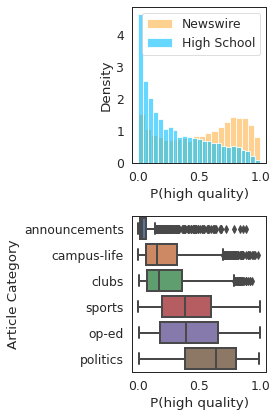

In [116]:
build_school_category_plot(high_schools, high_news)

In [129]:
# sample 10K opinion articles
opeds = high_schools.loc[high_schools.category.apply(lambda x: "opinion" in x)].sample(10000).copy().reset_index()


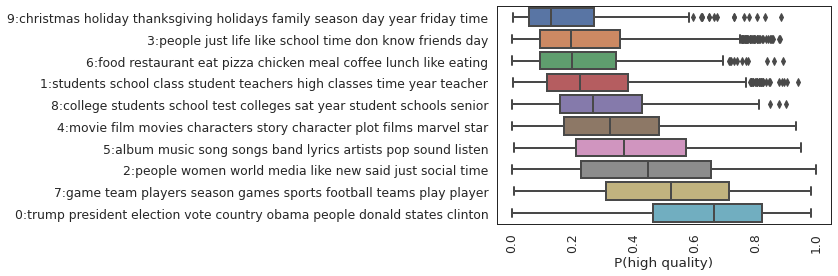

In [130]:
# cluster text via prob high quality
opeds = cluster_text(opeds, num_clusters=10, num_words=10, plot_boxplot=True)

## Document Regression

In [131]:
from data.featurize import text_featurize

In [132]:
text_features = text_featurize(opeds)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [133]:
formula = "prob_high_quality~ 1 + num_tokens + first_person + third_person + topic" 
model = smf.ols(formula=formula, data=text_features).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      prob_high_quality   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     382.9
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:43:11   Log-Likelihood:                 1635.2
No. Observations:               10000   AIC:                            -3244.
Df Residuals:                    9987   BIC:                            -3151.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5989      0.008     74.288   

## Demographic Feature Exploration

In [433]:
from data.viz import build_correlation_plots

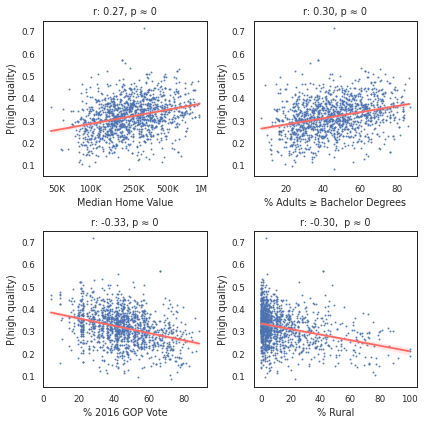

In [434]:
features_ = preprocess(features, REGRESSION_FEATURES, impute_only=True)
build_correlation_plots(features_, save=True, save_path='scatters.pdf')

## Demographic Regressions

In [437]:
import statsmodels.formula.api as smf
from data.constants import REGRESSION_FEATURES


In [438]:
features_ = preprocess(features, REGRESSION_FEATURES)
features_.shape

(1410, 300)

In [435]:
formula = """
        prob_high_quality ~ 
        1 +
        mixed_ratio +
        pacific_islander_ratio + 
        hispanic_ratio +
        asian_ratio +
        black_ratio +
        native_ratio +
        pupil_ratio +
        school_size + 
        city + 
        rural + 
        suburb + 
        is_charter + 
        is_magnet  + 
        is_private 
        """

model = smf.ols(formula=formula, data=features_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      prob_high_quality   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     8.456
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           1.99e-17
Time:                        13:05:39   Log-Likelihood:                 1167.0
No. Observations:                 974   AIC:                            -2304.
Df Residuals:                     959   BIC:                            -2231.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [445]:
from scipy import stats
stats.pearsonr(features_['school_size'], features_['fte_teachers'])

(0.8343347471925298, 0.0)

In [444]:
formula = """
        prob_high_quality ~ 
        1 +
        mixed_ratio +
        hispanic_ratio +
        asian_ratio +
        black_ratio +
        native_ratio +
        pupil_ratio +
        school_size + 
        urban_top_30  +
        rural_top_30 +
        is_charter + 
        is_magnet  + 
        is_private + 
        num_degree_holders + 
        median_home_value
        """

model = smf.ols(formula=formula, data=features_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      prob_high_quality   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     17.94
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           1.57e-41
Time:                        13:07:43   Log-Likelihood:                 1720.2
No. Observations:                1410   AIC:                            -3410.
Df Residuals:                    1395   BIC:                            -3332.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3186 

## TOEFL Exam Regression

In [136]:
toefl_exams = load_and_score(DATA_DIR / 'toefl.jsonl')

  0%|          | 0/12100 [00:00<?, ?it/s]

  0%|          | 0/12100 [00:00<?, ?it/s]

In [137]:
model = "C(score_level, Treatment(reference='medium')) + prompt"
formula = "prob_high_quality~ 1 + " + model
#formula = "log_prob_high_quality ~ 1  +  pop_urban + fte_teacher + dem_share  + proportion_white + pupil_ratio + income + asian  + mixed   + black"
model = smf.ols(formula=formula, data=toefl_exams).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      prob_high_quality   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     3315.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:45:12   Log-Likelihood:                 6650.6
No. Observations:               12100   AIC:                        -1.328e+04
Df Residuals:                   12090   BIC:                        -1.321e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [154]:
toefl_exams.groupby(['prompt', 'prompt_text']).prob_high_quality.mean().sort_values()

prompt  prompt_text                                                                                                                                                                                                                        
P7      Do you agree or disagree with the following statement?\n\nIt is more important for students to understand ideas and concepts than it is for them to learn facts.\n\nUse reasons and examples to support your answer.\n                 0.041906
P6      Do you agree or disagree with the following statement?\n\nThe best way to travel is in a group led by a tour guide.\n\nUse reasons and examples to support your answer.\n                                                              0.049652
P1      Do you agree or disagree with the following statement?\n\nIt is better to have broad knowledge of many academic subjects than to specialize in one specific subject.\n\nUse specific reasons and examples to support your answer.\n    0.071190
P2      Do you agree